# Watermark Image Classification

In [ ]:
%pip install fastai==1.0.61

### Importing modules

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
from pathlib import Path
import fastai
from fastai.tabular import *
from fastai.text import *
from fastai.vision import *
from fastai import *
import torch
from fastai.callbacks.hooks import *
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)

In [2]:
import warnings
warnings.filterwarnings('ignore')

Я использовал Kaggle для работы, чтобы быстрее обучать модели, а также библиотеку Fastai для быстрого дообучения моделей таких как resnet и densenet

Посмотрим на изображения

In [3]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv('/kaggle/input/content/train', csv_name = 'train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .transform(tfms, size=400)
        .databunch(num_workers=0,bs=8))

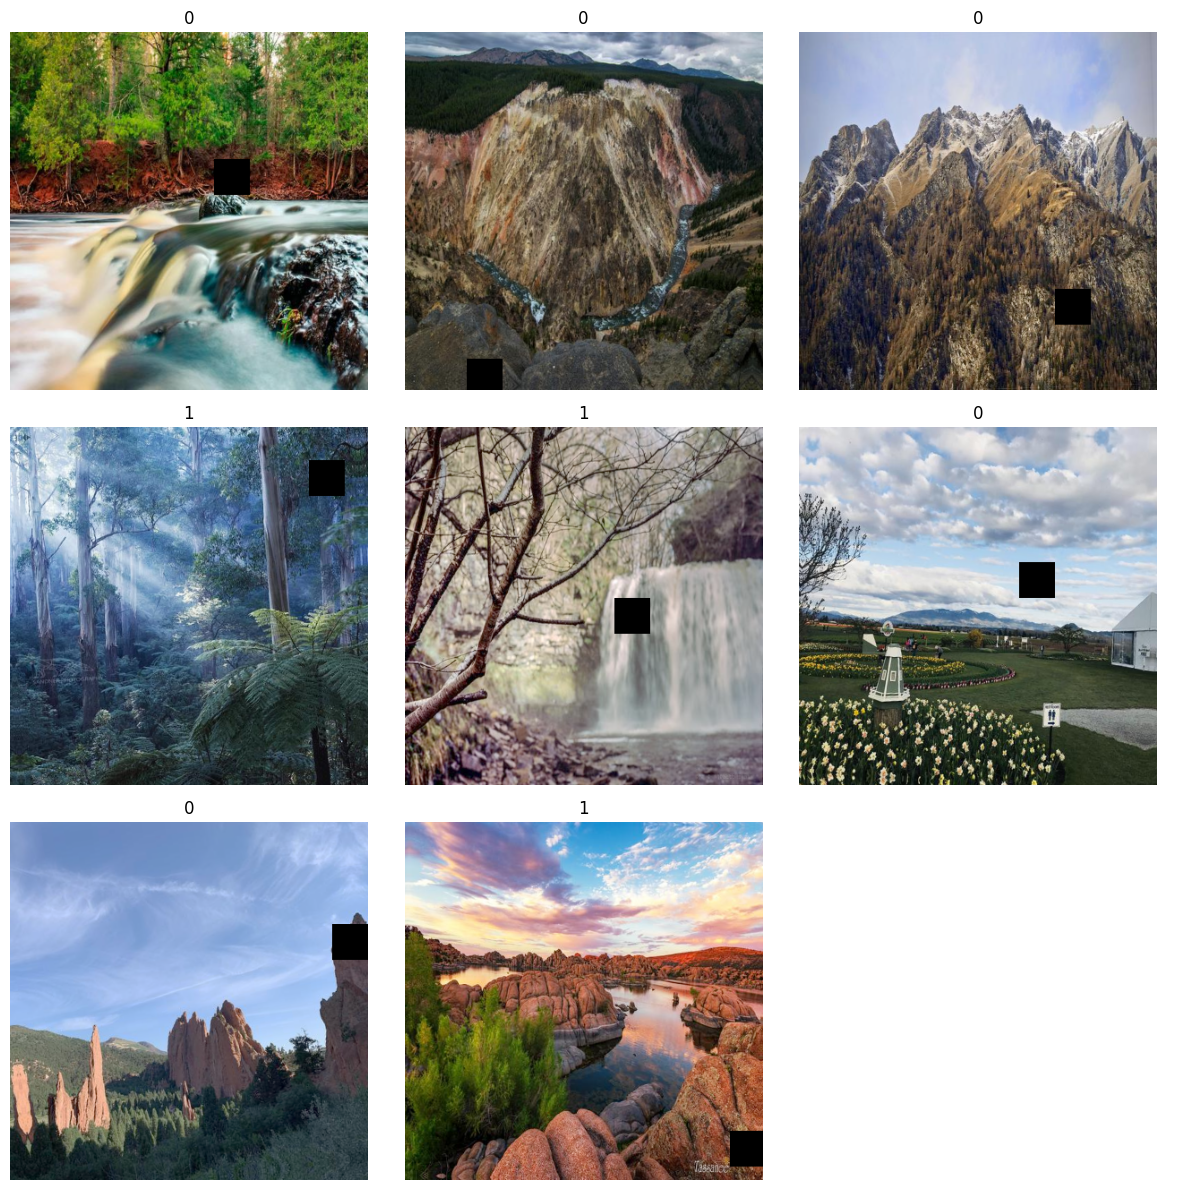

In [4]:
data.show_batch()

In [5]:
print(data.classes)

[0, 1]


Читаем данные и создаем ImageList из библиотеки Fastai для эффективной работы над изображениями

In [7]:
df_train = pd.read_csv('/kaggle/input/content/train/train.csv')
df_test = pd.read_csv('/kaggle/input/test-data/test/test.csv')

In [8]:
src = (ImageList.from_df(df_train, path='/kaggle/input/content/train').split_by_rand_pct()
       .label_from_df())

In [9]:
src.lists

[LabelList (12747 items)
 x: ImageList
 Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
 y: CategoryList
 0,0,0,0,1
 Path: /kaggle/input/content/train,
 LabelList (3186 items)
 x: ImageList
 Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
 y: CategoryList
 1,1,1,1,1
 Path: /kaggle/input/content/train]

In [ ]:
test_preds_all = []
val_preds_all = []
src = (ImageList.from_df(df_train, path='/kaggle/input/content/train').split_by_rand_pct()
                                                    .label_from_df())
# Создаем DataBunch для разбиения фоток на батчи
data = ImageDataBunch.create_from_ll(src, size=224, bs=8).normalize(imagenet_stats)
# Добавляем тестовые данные
data.add_test(ImageList.from_df(df_test, path='/kaggle/input/test-data/test'))
# Создаем learner для дообучения модели
learn = cnn_learner(data, models.densenet201, metrics=[accuracy, error_rate], ps=0.5)
learn.fit_one_cycle(10)
val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
val_preds = np.exp(val_preds.numpy())

Получаем результаты на тесте и валидации

In [ ]:
# Первый способ
test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
test_preds_all.append(test_preds)
val_preds_all.append(val_preds)
test_preds_all = np.mean(test_preds_all, axis=0)
val_preds_all = np.concatenate(val_preds_all, axis=0)

In [22]:
# Второй способ
test_preds = learn.get_preds(ds_type=DatasetType.Test)
test_pred_1 = np.exp(test_preds[0].numpy())
np.argmax(test_pred_1, axis=1)

### Submit file

In [24]:
sub=df_test[['Image']]
sub['Label']=np.argmax(test_pred_1,axis=1)
sub[['Label']].to_csv('dense201.csv',index=False)

### Results

In [4]:
pd.DataFrame([[0.65], [0.75], [0.80], [0.87], [0.87], [0.91]], columns=['Accuracy'], index=['DeepLearn', 'CNN', 'Resnet34', 'Resnet101', 'Densenet169', 'Densenet201'])

,Accuracy
DeepLearn,0.65
CNN,0.75
Resnet34,0.80
Resnet101,0.87
Densenet169,0.87
Densenet201,0.91
